In [5]:
#1-1 Case 1: Only Detecting Vehicle(Project 5)
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    data_dict["max_value"] = np.max(example_img)
    data_dict["min_value"] = np.min(example_img)
    # Return data_dict
    return data_dict

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print("Images is converted to ",color_space)
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)             

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            if scale==1:
                c = (255,0,0)
            elif scale==1.5:
                c = (0,255,0)
            else:
                c = (0,0,255)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),c,6)     
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Input Text on top of the box
        cv2.rectangle(img, (bbox[0][0],bbox[0][1]-40), (bbox[0][0]+75,bbox[0][1]), (0,0,255), -1)
        cv2.putText(img,"Car",(bbox[0][0]+5,bbox[0][1]-12), cv2.FONT_HERSHEY_SIMPLEX, 1.2,(255,255,255),2)
    # Return the image
    return img

def start(img):                   
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    origin_img = np.copy(img)
    box_list=[]
    scalelist = [1,1.5,2]    
    for scale in scalelist:
        if(scale==1):            
            ystart = 400
            ystop = 500
        elif(scale==1.5):
            ystart = 400
            ystop = 600 
        else:
            ystart = 400
            ystop = 656
        origin_img, box_list = find_cars(origin_img, box_list, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)        
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)    
    # Apply threshold to help remove false positives
    heat2 = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat2, 0, 255)    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)            
    return origin_img,heat,heat2,heatmap,draw_img,labels

In [2]:
#1-2 Extract features from training images for Case 1
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time
import pickle
import os.path
%matplotlib inline

cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')

#Parameters to extract features
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32    
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True
hog_feat = True
hist_feat = True

print("Extracting features from training images..")
if os.path.isfile('car_features.pickle'):
    with open('car_features.pickle', 'rb') as handle:
        data = pickle.load(handle)
        car_features, notcar_features = data['car'], data['notcar']
else:
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)    
    data = {'car':car_features,'notcar':notcar_features}
    with open('car_features.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')
        
#Normalizing training images
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("Shape of scaled_X :",scaled_X.shape)
print("Shape of Y : ",y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', 
      cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

# Use a linear SVC as a classifier
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Extracting features from training images..
Shape of scaled_X : (17760, 8460)
Shape of Y :  (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
X_train:  (14208, 8460)
y_train:  (14208,)
X_test:  (3552, 8460)
y_test:  (3552,)
20.27 Seconds to train SVC...
Test Accuracy of SVC =  0.9947


(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


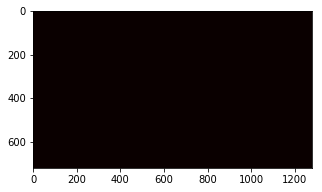

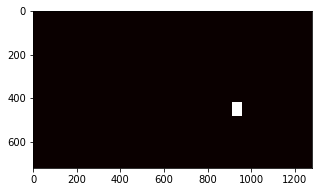

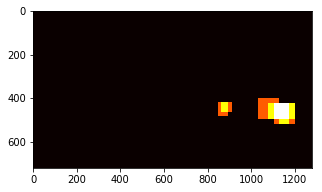

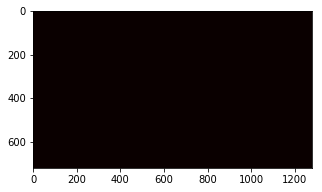

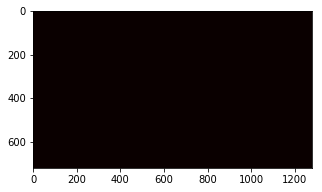

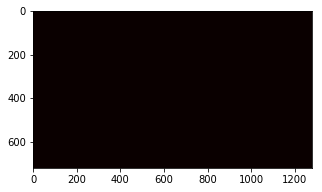

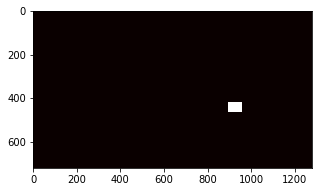

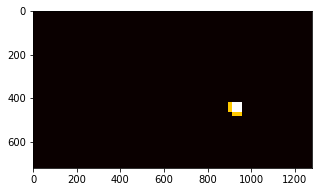

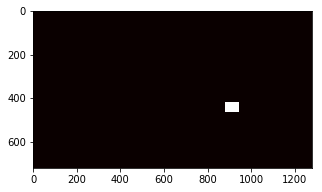

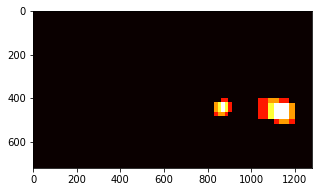

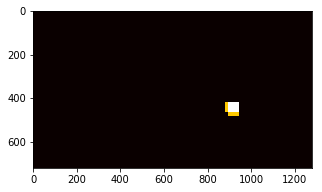

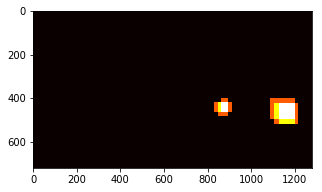

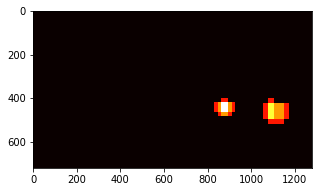

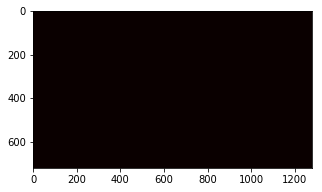

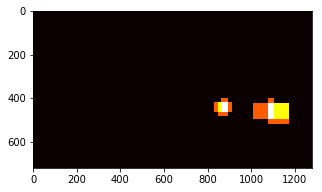

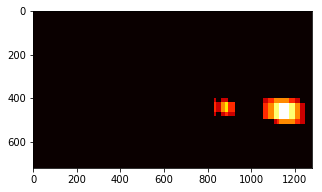

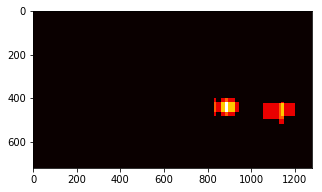

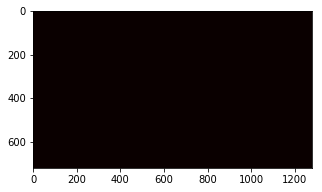

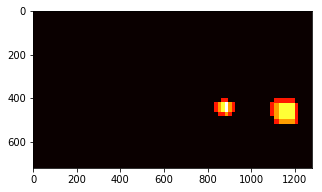

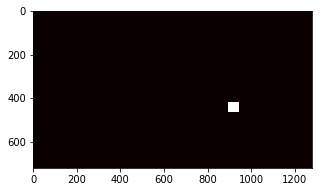

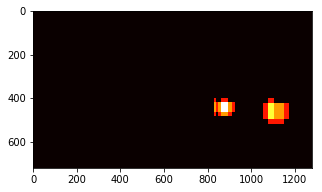

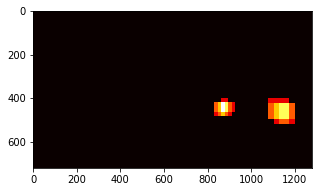

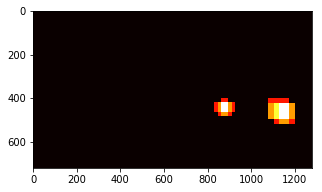

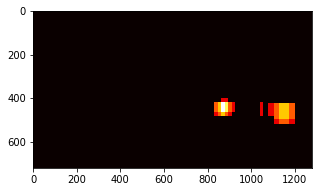

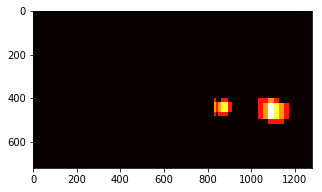

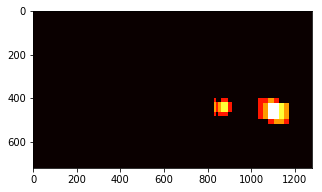

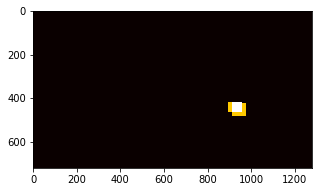

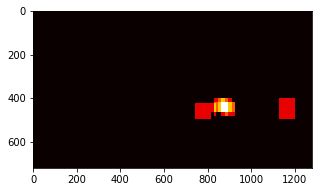

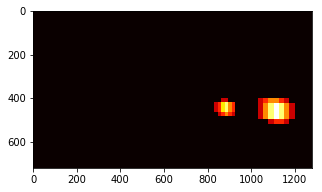

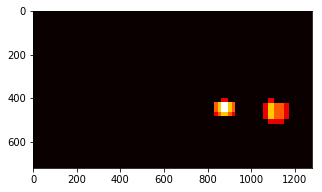

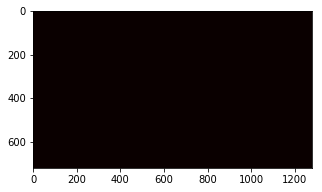

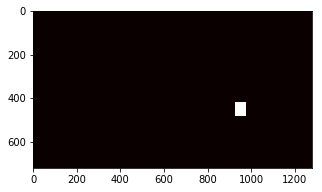

In [7]:
for img in test_img: 
    img = mpimg.imread(img)
    orgin_img,heat,heat2,heatmap,draw_img,labels = start(img)     
    fig, axes = plt.subplots(1,1, figsize=(5,5))                
    #axes.imshow(labels[0],cmap='gray')
    axes.imshow(heat,cmap='hot')

In [3]:
for num,img in enumerate(test_img): 
    img = mpimg.imread(img)
    origin_img,heat,heat2,heatmap,draw_img,labels = start(img)    
    fig, axes = plt.subplots(1,2, figsize=(15,15))            
    for idx,ax in enumerate(axes.flat):  
        if idx==0:
            ax.set_title('Window', fontsize=15)
            ax.imshow(origin_img)    
        if idx==1:
            ax.set_title('Heatmap', fontsize=15)
            ax.imshow(heat, cmap='hot')    


               
    #cv2.imwrite('output_images/sliding_window'+str(num)+'.jpg',cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    #axes.imshow(heat1)

NameError: name 'test_img' is not defined

/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


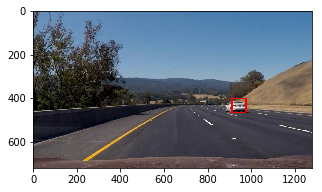

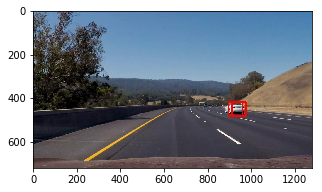

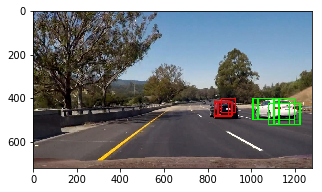

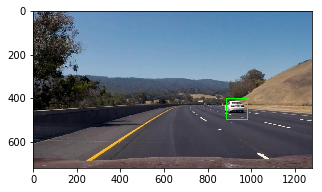

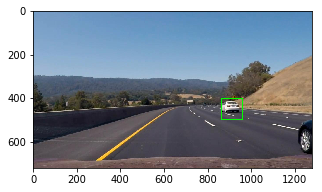

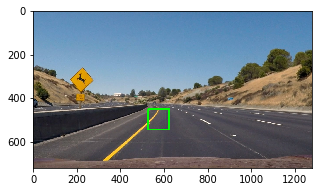

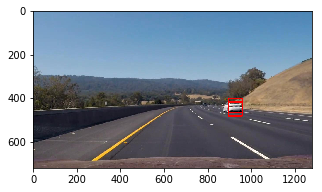

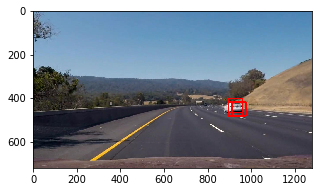

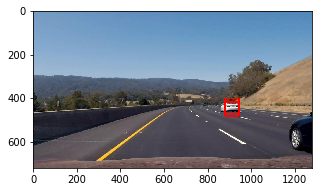

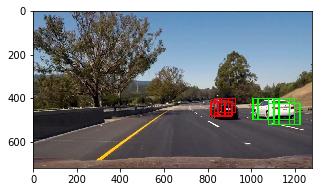

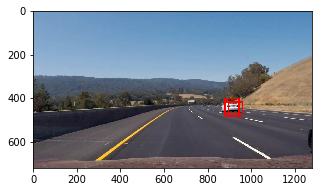

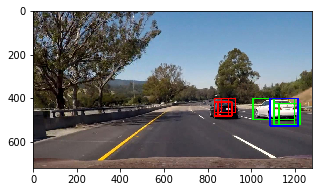

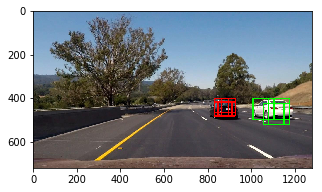

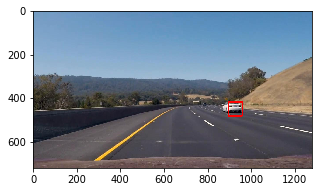

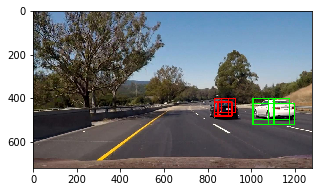

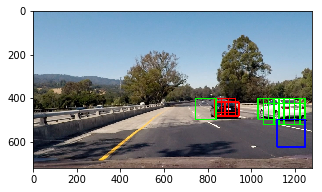

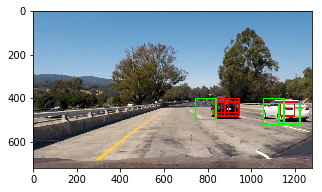

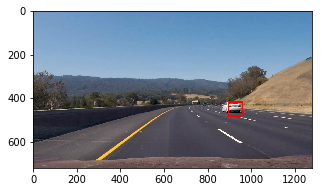

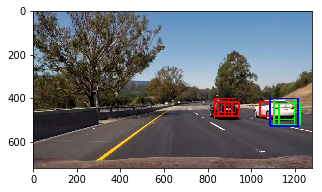

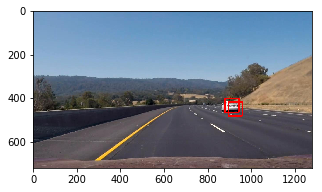

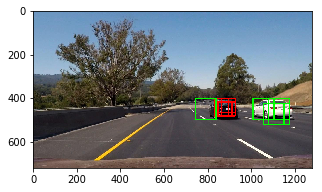

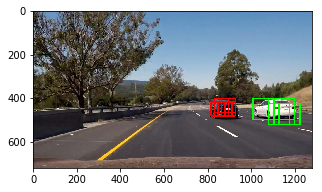

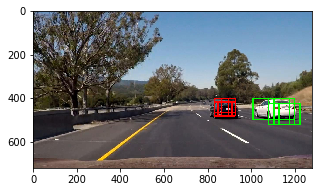

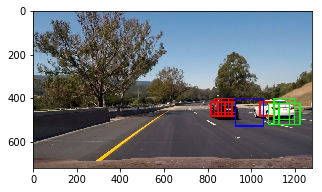

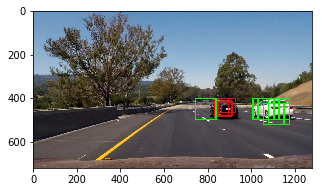

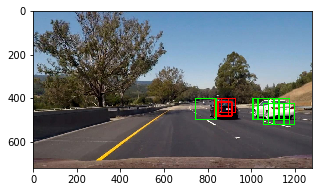

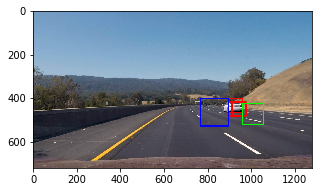

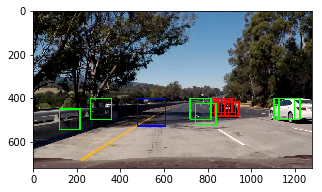

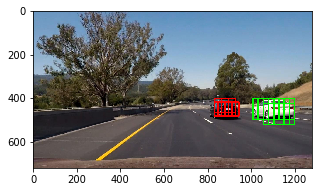

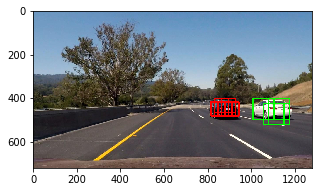

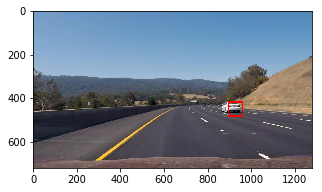

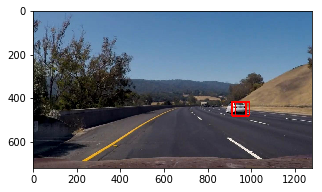

In [4]:
test_img = glob.glob('test_images/*.jpg')
for num,img in enumerate(test_img): 
    img = mpimg.imread(img)
    origin_img,heat,heat2,heatmap,draw_img,labels= start(img)    
    fig, axes = plt.subplots(1,1, figsize=(5,5))            
    #cv2.imwrite('output_images/sliding_window'+str(num)+'.jpg',cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    axes.imshow(origin_img)

Test Image size:  (720, 1280, 3)
Test Image data type:  uint8
Test Image[0] value range between  0  and  255


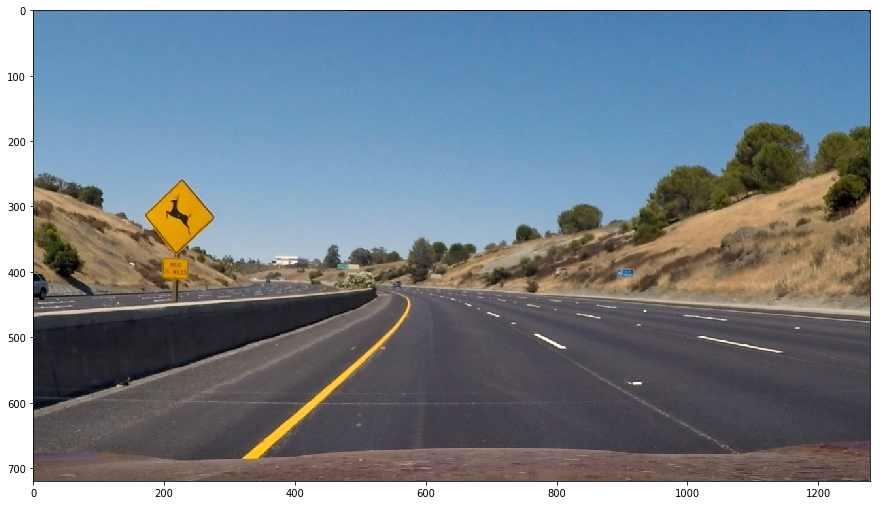

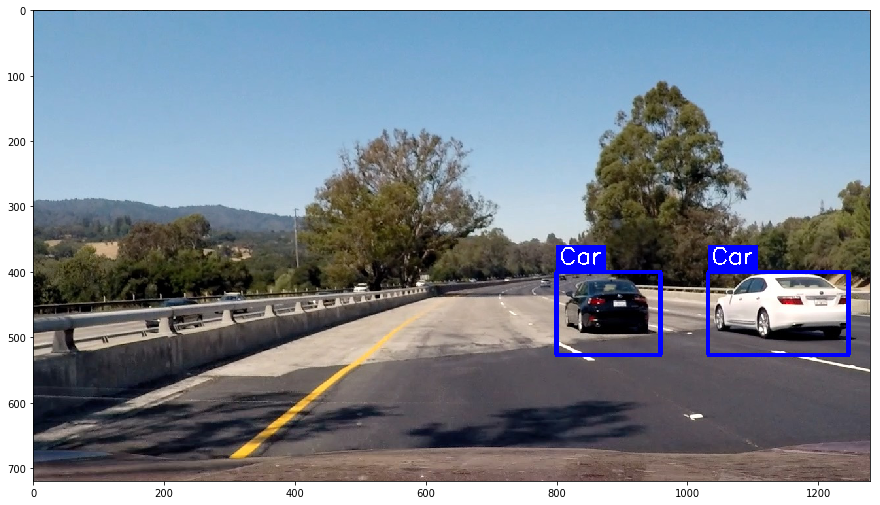

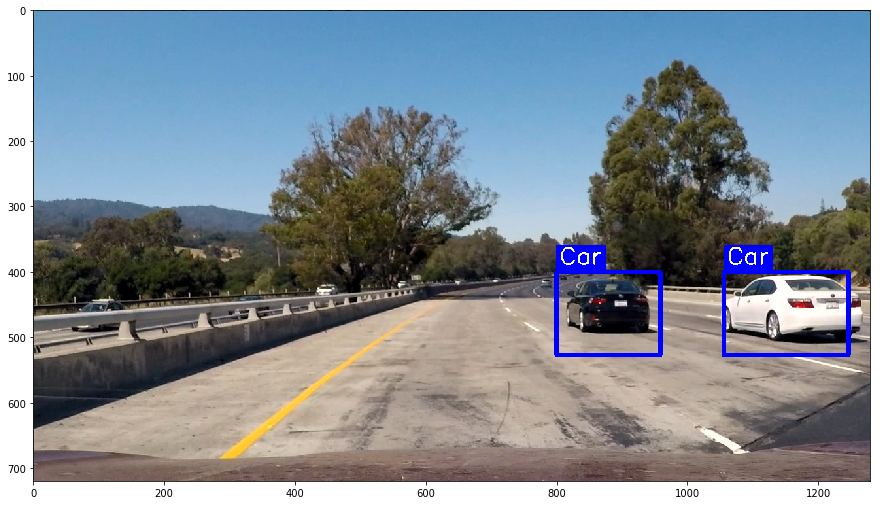

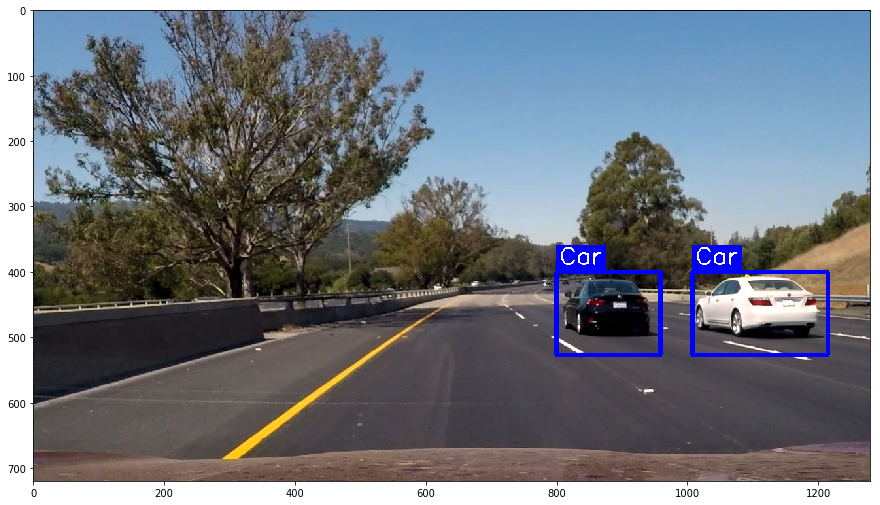

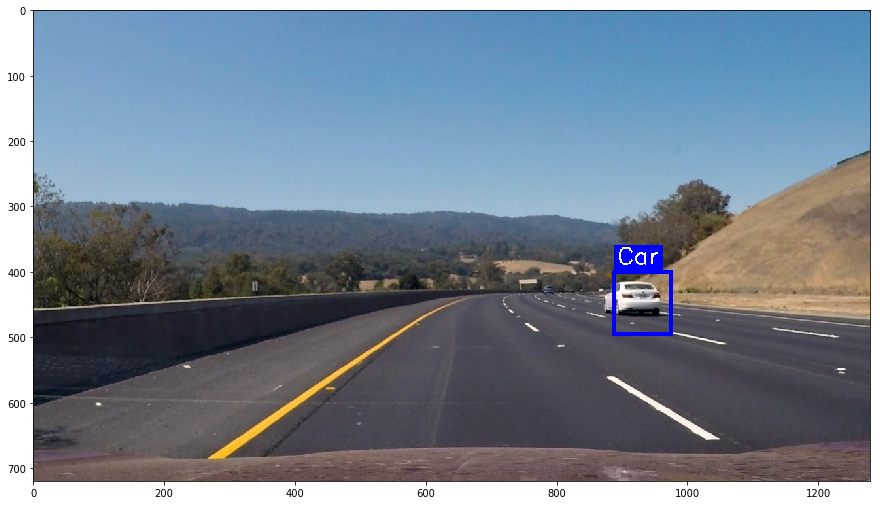

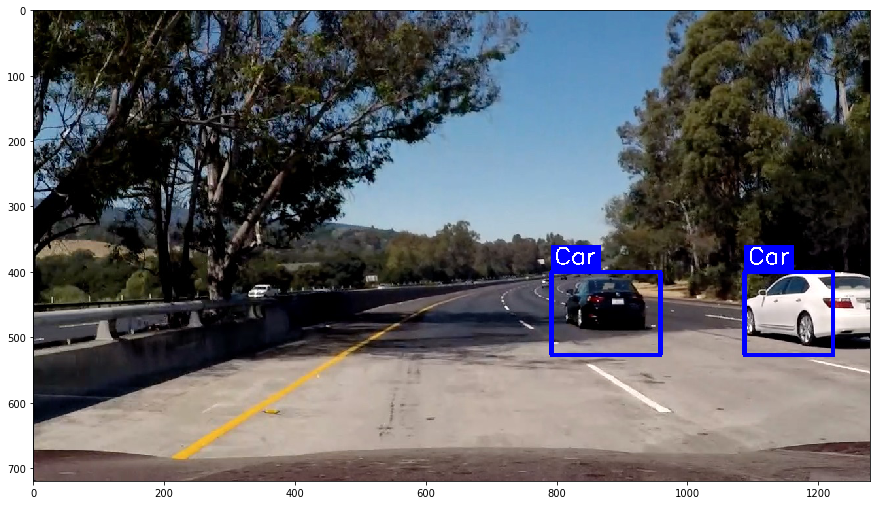

In [11]:
#1-3 Test with Images for Case 1

test_img = glob.glob('test_images/*.jpg')
data_info = data_look(test_img,[])
print('Test Image size: ',data_info["image_shape"])
print('Test Image data type: ',data_info["data_type"])
print('Test Image[0] value range between ',data_info["min_value"],' and ',data_info["max_value"])

for img in test_img: 
    img = mpimg.imread(img)
    draw_img = start(img)    
    fig, axes = plt.subplots(1,1, figsize=(15,15))            
    axes.imshow(draw_img)

In [ ]:
#1-4(Case 1 Finish) Making Movie Clip for Case 1

from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from P4_Lane_Detection import Line

clip = VideoFileClip("project_video.mp4")
output ="project_video_output.mp4"
output_clip = clip.fl_image(start)
%time output_clip.write_videofile(output, audio=False)